In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from tqdm.notebook import tqdm
from statsmodels.tsa.seasonal import STL                     # STL in offline mode
import src.online_decomposition.slidingSTL as slidingSTL     # STL in online mode (SlidingSTL)
import src.online_decomposition.ASTD as ASTD
import src.utilities.gen_synthetic as gen_syn


## Prepare data

In [2]:
syn1 = gen_syn.generate_syn1(is_export = False)
syn2 = gen_syn.generate_syn2(is_export = False)

results = []            # all results
season_lengths = np.arange(38, 160, 7)
datasets = [syn1, syn2]

## Reproduction for STL (offline mode)


In [3]:
"""
    OneShotSTL cannot export trend, seasonal, and residual components of the initialization phase. We must compute data that are processed in the online phase only for fair comparisons.
    The initialization phase of OneShotSTL require data with 5 * season length.
"""
pbar = tqdm(total=(len(datasets)*len(season_lengths)))
for season_length in season_lengths:
    trend_mse = []
    seasonal_mse = []
    residual_mse = []
    for dataset in datasets:
        stl_results = STL(dataset['ts'], period=season_length, robust=True).fit()
        trend_mse.append(metric.mean_squared_error(dataset['trend'][5 * season_length:],
                                              stl_results.trend[5 * season_length:]))
        seasonal_mse.append(metric.mean_squared_error(dataset['seasonal'][5 * season_length:],
                                                 stl_results.seasonal[5 * season_length:]))
        residual_mse.append(metric.mean_squared_error(dataset['residual'][5 * season_length:],
                                                 stl_results.resid[5 * season_length:]))
        pbar.update(1)
    results.append({'algorithm': 'STL',
                    'season_length': season_length,
                    'trend_mse': sum(trend_mse)/len(datasets),
                    'seasonal_mse': sum(seasonal_mse)/len(datasets),
                    'residual_mse': sum(residual_mse)/len(datasets)})
pbar.close()

  0%|          | 0/36 [00:00<?, ?it/s]

## Reproduction for SlidingSTL

In [4]:
pbar = tqdm(total=(len(datasets)*len(season_lengths)))
for season_length in season_lengths:
    trend_mse = []
    seasonal_mse = []
    residual_mse = []
    for dataset in datasets:
        ts_offline_phase = np.array(dataset['ts'][:season_length * 5])
        ts_online_phase = np.array(dataset['ts'][season_length * 5:])
        
        core_slidingSTL = slidingSTL.slidingSTL(max_season_length=season_length, max_cycles =5)
        slidingSTL_trend, slidingSTL_seasonal, slidingSTL_residual = core_slidingSTL.initialize_phase(ts_offline_phase)

        for y_t in ts_online_phase:
            t_t, s_t, r_t = core_slidingSTL.online_update(y_t)
            slidingSTL_trend = np.append(slidingSTL_trend, t_t)
            slidingSTL_seasonal = np.append(slidingSTL_seasonal, s_t)
            slidingSTL_residual = np.append(slidingSTL_residual, r_t)
            
        trend_mse.append(metric.mean_squared_error(dataset['trend'][5 * season_length:],slidingSTL_trend[5 * season_length:]))
        seasonal_mse.append(metric.mean_squared_error(dataset['seasonal'][5 * season_length:],slidingSTL_seasonal[5 * season_length:]))
        residual_mse.append(metric.mean_squared_error(dataset['residual'][5 * season_length:],slidingSTL_residual[5 * season_length:]))
            
        pbar.update(1)
    
    results.append({'algorithm': 'slidingSTL',
                    'season_length': season_length,
                    'trend_mse': sum(trend_mse)/len(datasets),
                    'seasonal_mse': sum(seasonal_mse)/len(datasets),
                    'residual_mse': sum(residual_mse)/len(datasets)})
    
pbar.close()

  0%|          | 0/36 [00:00<?, ?it/s]

In [5]:
window_size = 300
trend_results = []
seasonal_results = []
residual_results = []
for dataset in datasets:
    ts_offline_phase = dataset['ts'][:window_size]
    ts_online_phase = dataset['ts'][window_size:]

    core_STL = ASTD.ASTD(window_size=window_size, seasonality_smoothing=0.7)

    # initialize phase
    ASTD_trend, ASDT_seasonal, ASTD_residual = core_STL.initialization_phase(ts_offline_phase)

    # Online updating phase
    with tqdm(total=len(ts_online_phase), desc="ASTD (Online phase)") as pbar:
        for y_t in ts_online_phase:
            t_t, s_t, r_t = core_STL.update_phase(y_t)
            ASTD_trend = np.append(ASTD_trend, t_t)
            ASDT_seasonal = np.append(ASDT_seasonal, s_t)
            ASTD_residual = np.append(ASTD_residual, r_t)
            
            pbar.update(1)

    trend_results.append(ASTD_trend)
    seasonal_results.append(ASDT_seasonal)
    residual_results.append(ASTD_residual)

for season_length in season_lengths:
    trend_mse = []
    seasonal_mse = [] 
    residual_mse = []
    for i in range(len(datasets)):
        trend_mse.append(metric.mean_squared_error(datasets[i]['trend'][5 * season_length:],trend_results[i][5 * season_length:]))
        seasonal_mse.append(metric.mean_squared_error(datasets[i]['seasonal'][5 * season_length:],seasonal_results[i][5 * season_length:]))
        residual_mse.append(metric.mean_squared_error(datasets[i]['residual'][5 * season_length:],residual_results[i][5 * season_length:]))
        
    results.append({'algorithm': 'ASTD',
                    'season_length': season_length,
                    'trend_mse': sum(trend_mse)/len(datasets),
                    'seasonal_mse': sum(seasonal_mse)/len(datasets),
                    'residual_mse': sum(residual_mse)/len(datasets)})

ASTD (Online phase):   0%|          | 0/4700 [00:00<?, ?it/s]

ASTD (Online phase):   0%|          | 0/4656 [00:00<?, ?it/s]

## plot Fig6a (trend MSE)

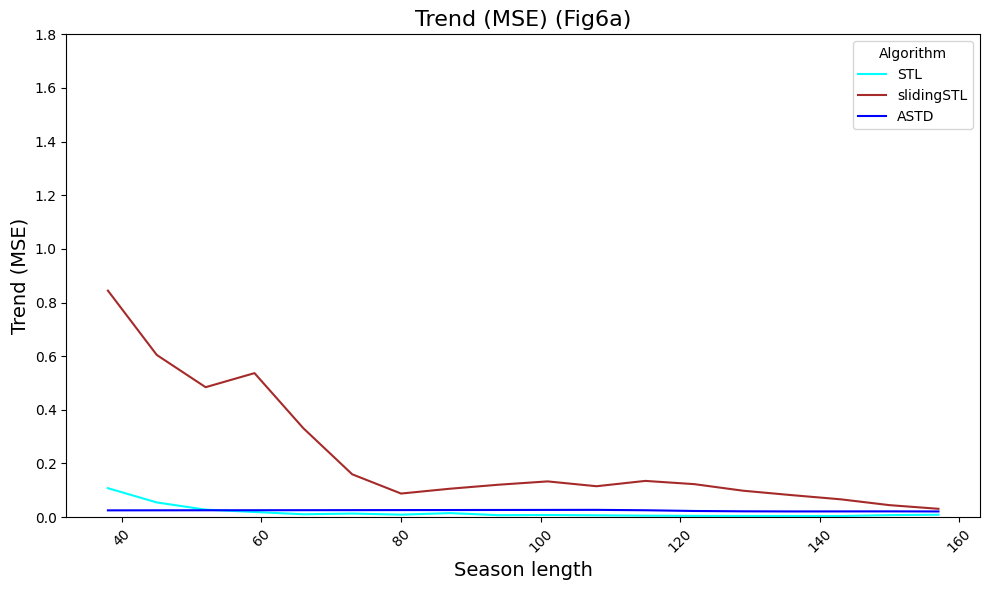

In [6]:
df = pd.DataFrame(results)

algorithms = ['STL', 'slidingSTL', 'ASTD']
colors = ['aqua', 'brown', 'blue']

plt.figure(figsize=(10, 6))

for algorithm, color in zip(algorithms, colors):
    subset = df[df['algorithm'] == algorithm]
    plt.plot(subset['season_length'], subset['trend_mse'], linestyle='-', color=color, label=algorithm)

plt.title('Trend (MSE) (Fig6a)', fontsize=16)
plt.xlabel('Season length', fontsize=14)
plt.ylabel('Trend (MSE)', fontsize=14) 
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.ylim(0,1.8)
plt.tight_layout()
plt.show()

## plot Fig6b (seasonal MSE)

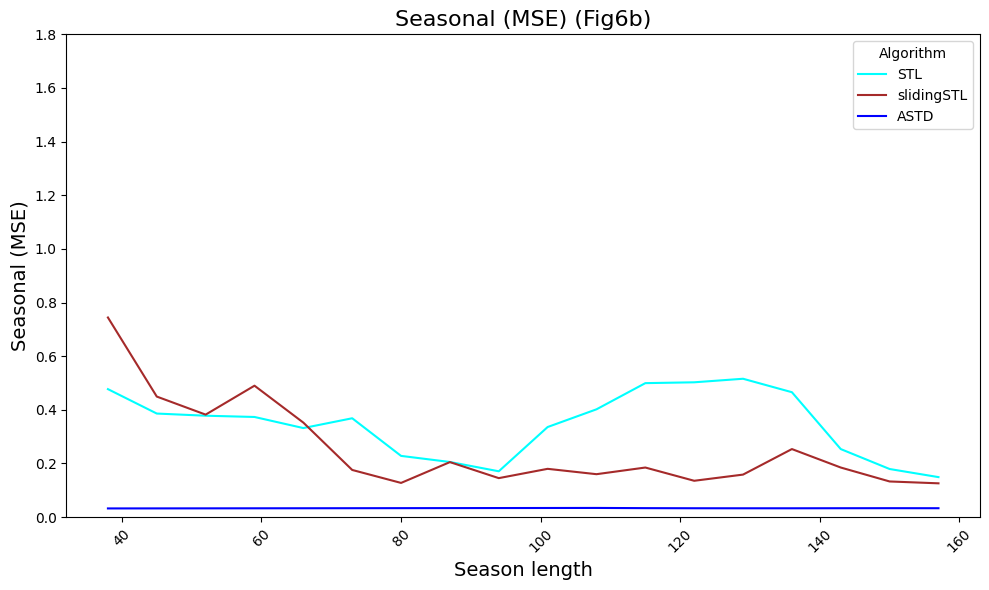

In [7]:
plt.figure(figsize=(10, 6))

for algorithm, color in zip(algorithms, colors):
    subset = df[df['algorithm'] == algorithm]
    plt.plot(subset['season_length'], subset['seasonal_mse'], linestyle='-', color=color, label=algorithm)

plt.title('Seasonal (MSE) (Fig6b)', fontsize=16)
plt.xlabel('Season length', fontsize=14)
plt.ylabel('Seasonal (MSE)', fontsize=14) 
plt.xticks(rotation=45)
plt.ylim(0,1.8)
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

## plot Fig6c (residual MSE)

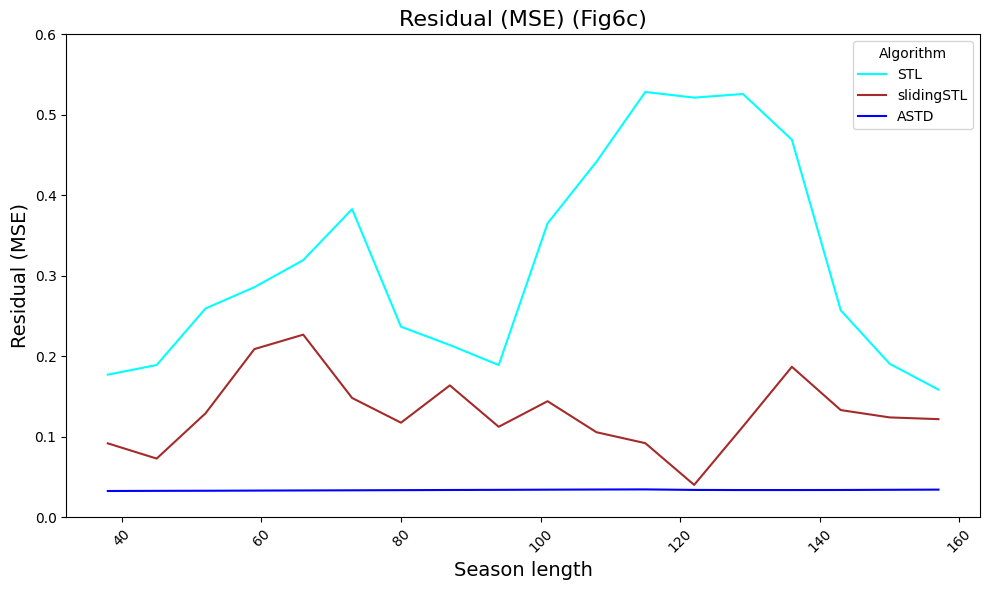

In [8]:
plt.figure(figsize=(10, 6))

for algorithm, color in zip(algorithms, colors):
    subset = df[df['algorithm'] == algorithm]
    plt.plot(subset['season_length'], subset['residual_mse'], linestyle='-', color=color, label=algorithm)

plt.title('Residual (MSE) (Fig6c)', fontsize=16)
plt.xlabel('Season length', fontsize=14)
plt.ylabel('Residual (MSE)', fontsize=14) 
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.tight_layout()
plt.ylim(0,0.6)
plt.show()

In [16]:
syn3 = gen_syn.generate_syn3(is_export = False)

results_syn3 = []            # all results
season_lengths = np.arange(38, 160, 7)
datasets = [syn3]

## Reproduction for STL (offline mode)

In [17]:
"""
    OneShotSTL cannot export trend, seasonal, and residual components of the initialization phase. We must compute data that are processed in the online phase only for fair comparisons.
    The initialization phase of OneShotSTL require data with 5 * season length.
"""
pbar = tqdm(total=(len(datasets)*len(season_lengths)))
for season_length in season_lengths:
    trend_mse = []
    seasonal_mse = []
    residual_mse = []
    for dataset in datasets:
        stl_results = STL(dataset['ts'], period=season_length, robust=True).fit()
        trend_mse.append(metric.mean_squared_error(dataset['trend'][5 * season_length:],
                                              stl_results.trend[5 * season_length:]))
        seasonal_mse.append(metric.mean_squared_error(dataset['seasonal'][5 * season_length:],
                                                 stl_results.seasonal[5 * season_length:]))
        residual_mse.append(metric.mean_squared_error(dataset['residual'][5 * season_length:],
                                                 stl_results.resid[5 * season_length:]))
        pbar.update(1)
    results_syn3.append({'algorithm': 'STL',
                    'season_length': season_length,
                    'trend_mse': sum(trend_mse)/len(datasets),
                    'seasonal_mse': sum(seasonal_mse)/len(datasets),
                    'residual_mse': sum(residual_mse)/len(datasets)})
pbar.close()

  0%|          | 0/18 [00:00<?, ?it/s]

##SlidingSTL

In [18]:
pbar = tqdm(total=(len(datasets)*len(season_lengths)))
for season_length in season_lengths:
    trend_mse = []
    seasonal_mse = []
    residual_mse = []
    for dataset in datasets:
        ts_offline_phase = np.array(dataset['ts'][:season_length * 5])
        ts_online_phase = np.array(dataset['ts'][season_length * 5:])
        
        core_slidingSTL = slidingSTL.slidingSTL(max_season_length=season_length, max_cycles =5)
        slidingSTL_trend, slidingSTL_seasonal, slidingSTL_residual = core_slidingSTL.initialize_phase(ts_offline_phase)

        for y_t in ts_online_phase:
            t_t, s_t, r_t = core_slidingSTL.online_update(y_t)
            slidingSTL_trend = np.append(slidingSTL_trend, t_t)
            slidingSTL_seasonal = np.append(slidingSTL_seasonal, s_t)
            slidingSTL_residual = np.append(slidingSTL_residual, r_t)
            
        trend_mse.append(metric.mean_squared_error(dataset['trend'][5 * season_length:],slidingSTL_trend[5 * season_length:]))
        seasonal_mse.append(metric.mean_squared_error(dataset['seasonal'][5 * season_length:],slidingSTL_seasonal[5 * season_length:]))
        residual_mse.append(metric.mean_squared_error(dataset['residual'][5 * season_length:],slidingSTL_residual[5 * season_length:]))
            
        pbar.update(1)
    
    results_syn3.append({'algorithm': 'slidingSTL',
                    'season_length': season_length,
                    'trend_mse': sum(trend_mse)/len(datasets),
                    'seasonal_mse': sum(seasonal_mse)/len(datasets),
                    'residual_mse': sum(residual_mse)/len(datasets)})
    
pbar.close()

  0%|          | 0/18 [00:00<?, ?it/s]

## Reproduction for ASTD

In [19]:
window_size = 300
trend_results = []
seasonal_results = []
residual_results = []
for dataset in datasets:
    ts_offline_phase = dataset['ts'][:window_size]
    ts_online_phase = dataset['ts'][window_size:]

    core_STL = ASTD.ASTD(window_size=window_size, seasonality_smoothing=0.7)

    # initialize phase
    ASTD_trend, ASDT_seasonal, ASTD_residual = core_STL.initialization_phase(ts_offline_phase)

    # Online updating phase
    with tqdm(total=len(ts_online_phase), desc="ASTD (Online phase)") as pbar:
        for y_t in ts_online_phase:
            t_t, s_t, r_t = core_STL.update_phase(y_t)
            ASTD_trend = np.append(ASTD_trend, t_t)
            ASDT_seasonal = np.append(ASDT_seasonal, s_t)
            ASTD_residual = np.append(ASTD_residual, r_t)
            
            pbar.update(1)

    trend_results.append(ASTD_trend)
    seasonal_results.append(ASDT_seasonal)
    residual_results.append(ASTD_residual)

for season_length in season_lengths:
    trend_mse = []
    seasonal_mse = [] 
    residual_mse = []
    for i in range(len(datasets)):
        trend_mse.append(metric.mean_squared_error(datasets[i]['trend'][5 * season_length:],trend_results[i][5 * season_length:]))
        seasonal_mse.append(metric.mean_squared_error(datasets[i]['seasonal'][5 * season_length:],seasonal_results[i][5 * season_length:]))
        residual_mse.append(metric.mean_squared_error(datasets[i]['residual'][5 * season_length:],residual_results[i][5 * season_length:]))
        
    results_syn3.append({'algorithm': 'ASTD',
                    'season_length': season_length,
                    'trend_mse': sum(trend_mse)/len(datasets),
                    'seasonal_mse': sum(seasonal_mse)/len(datasets),
                    'residual_mse': sum(residual_mse)/len(datasets)})

ASTD (Online phase):   0%|          | 0/4700 [00:00<?, ?it/s]

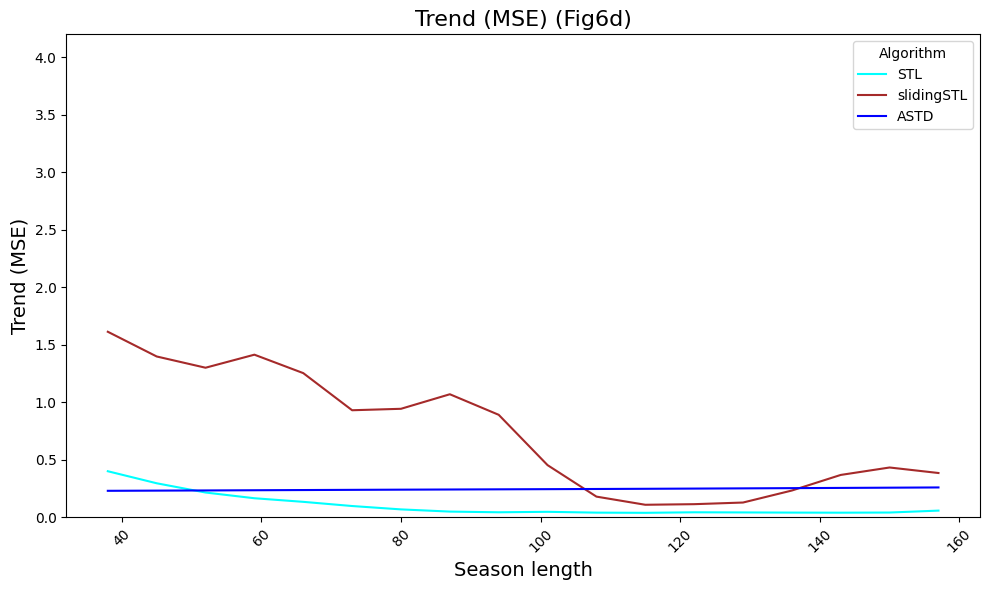

In [20]:
df = pd.DataFrame(results_syn3)

algorithms = ['STL', 'slidingSTL', 'ASTD']
colors = ['aqua', 'brown', 'blue']

plt.figure(figsize=(10, 6))

for algorithm, color in zip(algorithms, colors):
    subset = df[df['algorithm'] == algorithm]
    plt.plot(subset['season_length'], subset['trend_mse'], linestyle='-', color=color, label=algorithm)

plt.title('Trend (MSE) (Fig6d)', fontsize=16)
plt.xlabel('Season length', fontsize=14)
plt.ylabel('Trend (MSE)', fontsize=14) 
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.ylim(0,4.2)
plt.tight_layout()
plt.show()

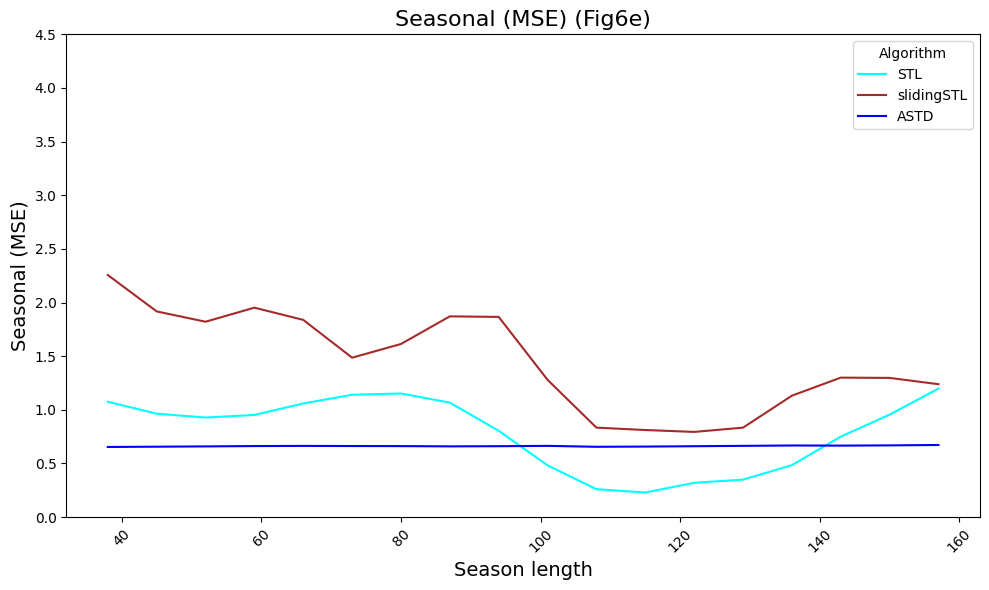

In [21]:
plt.figure(figsize=(10, 6))

for algorithm, color in zip(algorithms, colors):
    subset = df[df['algorithm'] == algorithm]
    plt.plot(subset['season_length'], subset['seasonal_mse'], linestyle='-', color=color, label=algorithm)

plt.title('Seasonal (MSE) (Fig6e)', fontsize=16)
plt.xlabel('Season length', fontsize=14)
plt.ylabel('Seasonal (MSE)', fontsize=14) 
plt.xticks(rotation=45)
plt.ylim(0,4.5)
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

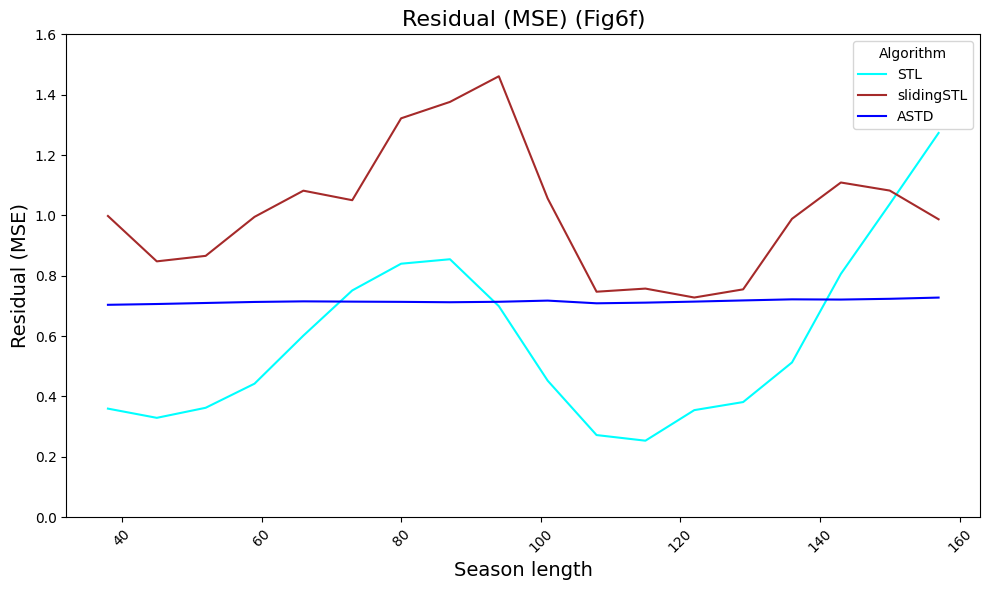

In [22]:
plt.figure(figsize=(10, 6))

for algorithm, color in zip(algorithms, colors):
    subset = df[df['algorithm'] == algorithm]
    plt.plot(subset['season_length'], subset['residual_mse'], linestyle='-', color=color, label=algorithm)

plt.title('Residual (MSE) (Fig6f)', fontsize=16)
plt.xlabel('Season length', fontsize=14)
plt.ylabel('Residual (MSE)', fontsize=14) 
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.tight_layout()
plt.ylim(0,1.6)
plt.show()